## Goal: Build classifier to distinguish AD cases from controls
Original paper: https://www.cell.com/current-biology/pdfExtended/S0960-9822(20)30291-8

In [ ]:
library(data.table)
library(tidyverse)
library(RColorBrewer)
library(reshape2)
library(gdata)
library(ggrepel)
library(DESeq2)
library(e1071)
library(ROCR)

In [2]:
setwd("~/coursework//cse283/project/")

In [3]:
# Read in counts table
counts.dt <- fread("./GSE136243_gene_TPM_all_samples.txt",stringsAsFactors = F)
head(counts.dt)

gene_id,gene_name,gene_biotype,C_1_01_1,AD_8_12_1,C_10_01_1,C_10_14_1,C_10_05_1,C_10_08_1,AD_11_08_1,⋯,AD_5_12_1,AD_5_13_1,AD_3_00_1,AD_3_01_1,AD_3_03_1,AD_2_01_1,AD_2_02_1,AD_2_03_1,AD_2_05_1,AD_2_07_1
ENSG00000223972,DDX11L1,transcribed_unprocessed_pseudogene,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000227232,WASH7P,unprocessed_pseudogene,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,11.62609,5.503961
ENSG00000278267,MIR6859-1,miRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000243485,RP11-34P13.3,lincRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000274890,MIR1302-2,miRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000237613,FAM138A,lincRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000


In [4]:
# get sample names and add to meta table
samp.dt <- data.frame(sample_id=colnames(counts.dt)[4:length(colnames(counts.dt))],stringsAsFactors = F) %>%
    mutate(donorID = sapply(sample_id,function(x) {
        t <- str_split(x,"_")[[1]]
        return(paste0(t[1],"_",t[2]))
    })) %>%
    mutate(year = as.numeric(sapply(sample_id,function(x) {
        t <- str_split(x,"_")[[1]]
        return(paste0("20",t[3]))
    }))) 
# head(samp.dt)

### Sample information table + year away from AD diagnosis
meta.dt <- fread("./donor_info.csv",stringsAsFactor=F) %>%
    full_join(.,samp.dt,by="donorID") %>%
    mutate(yr_since_diag = as.numeric(year)-as.numeric(Year_diagnosis))
dim(meta.dt)
head(meta.dt)

[1] 164  10

donorID,group,age_death,sex,braak_stage,Year_diagnosis,APOE_status,sample_id,year,yr_since_diag
N_1,control,86,M,1,NA,ε3/ε4,N_1_01_1,2001,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_05_1,2005,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_07_1,2007,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_08_1,2008,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_09_1,2009,NA
N_2,control,93,F,1,NA,ε3/ε3,N_2_00_1,2000,NA


In [5]:
# counts table into long format and join in sample info
counts.longdt <- counts.dt %>%
    melt(id.vars=c("gene_id", "gene_name", "gene_biotype"), value.name = "count", variable.name = "sample_id") %>%
    left_join(.,meta.dt,by="sample_id")
head(counts.longdt)

# Save file
fwrite(counts.longdt, "./gene_counts_sample_info.csv", row.names = F)

Warning message:
“Column `sample_id` joining factor and character vector, coercing into character vector”

gene_id,gene_name,gene_biotype,sample_id,count,donorID,group,age_death,sex,braak_stage,Year_diagnosis,APOE_status,year,yr_since_diag
ENSG00000223972,DDX11L1,transcribed_unprocessed_pseudogene,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000227232,WASH7P,unprocessed_pseudogene,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000278267,MIR6859-1,miRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000243485,RP11-34P13.3,lincRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000274890,MIR1302-2,miRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000237613,FAM138A,lincRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9


### DESEQ

In [15]:
counts.mat <- counts.dt %>%
    select(meta.dt$sample_id) %>% # ensure columns are in same order as meta dt
    as.matrix   
rownames(counts.mat) <- counts.dt$gene_id

# round counts for DESeq
counts.mat <- round(counts.mat)
head(counts.mat)

,N_1_01_1,N_1_05_1,N_1_07_1,N_1_08_1,N_1_09_1,N_2_00_1,N_2_01_1,N_2_03_1,N_2_06_1,N_2_08_1,⋯,C_10_14_1,C_10_05_1,C_10_08_1,C_10_03_1,C_10_10_1,C_10_13_1,C_11_09_1,C_11_01_1,C_11_03_1,C_11_04_1
ENSG00000223972,0,0,0,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,26,0,0,0,0
ENSG00000278267,0,0,0,0,0,0,0,120,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,3,0,0,8,0,0,0
ENSG00000274890,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [16]:
# ### run DESeq for condition - take a long time
# dds <- DESeqDataSetFromMatrix(counts.mat, colData = meta.dt, design = ~group) 

# # run DESeq for 
# start.time <- Sys.time()
# dds <- DESeq(dds)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [17]:
# # pull out top genes DE between AD and controls
# res <- results(dds, contrast=c("group", "control","AD")) %>%
#     as.data.frame() %>%
#     rownames_to_column("gene_id") %>%
#     left_join(., distinct(select(counts.dt, gene_id,gene_name,gene_biotype)), by = "gene_id") %>%
#     arrange(padj)
# head(res)
# fwrite(res, "./control_AD_DE_genes.csv",row.names=F)

In [18]:
# res %>%
#     filter(padj < 0.05) %>% head(n=50)

In [19]:
# # simple PCA of different samples
# # regularized log transform count data to log2 scale for variance stabilizing effect, convert to matrix
# start.time <- Sys.time()
# rld <- assay(varianceStabilizingTransformation(dds))
# pca <- prcomp(t(rld))
# summary(pca)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [20]:
# # Plot PCA
# pca.dt <- cbind(meta.dt, pca$x)
# ggplot(pca.dt, aes(x=PC1, PC2, color = group)) + geom_point() #+ geom_text_repel()

In [21]:
# vs <- vst(counts.mat)
# pca <- prcomp(t(vs))
# summary(pca)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

## PCA

In [22]:
## compute PCA
pca <- prcomp(t(counts.mat))
summary(pca)

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     5.967e+04 2.447e+04 1.479e+04 1.011e+04 7.867e+03
Proportion of Variance 7.433e-01 1.250e-01 4.566e-02 2.133e-02 1.292e-02
Cumulative Proportion  7.433e-01 8.683e-01 9.140e-01 9.353e-01 9.483e-01
                             PC6       PC7       PC8       PC9      PC10
Standard deviation     7.499e+03 5.761e+03 4151.0881 3.626e+03 3.519e+03
Proportion of Variance 1.174e-02 6.930e-03    0.0036 2.750e-03 2.590e-03
Cumulative Proportion  9.600e-01 9.669e-01    0.9705 9.733e-01 9.759e-01
                            PC11      PC12      PC13      PC14      PC15
Standard deviation     3.119e+03 2.865e+03 2.568e+03 2.208e+03 2.138e+03
Proportion of Variance 2.030e-03 1.710e-03 1.380e-03 1.020e-03 9.500e-04
Cumulative Proportion  9.779e-01 9.796e-01 9.810e-01 9.820e-01 9.830e-01
                            PC16      PC17      PC18      PC19      PC20
Standard deviation     1.

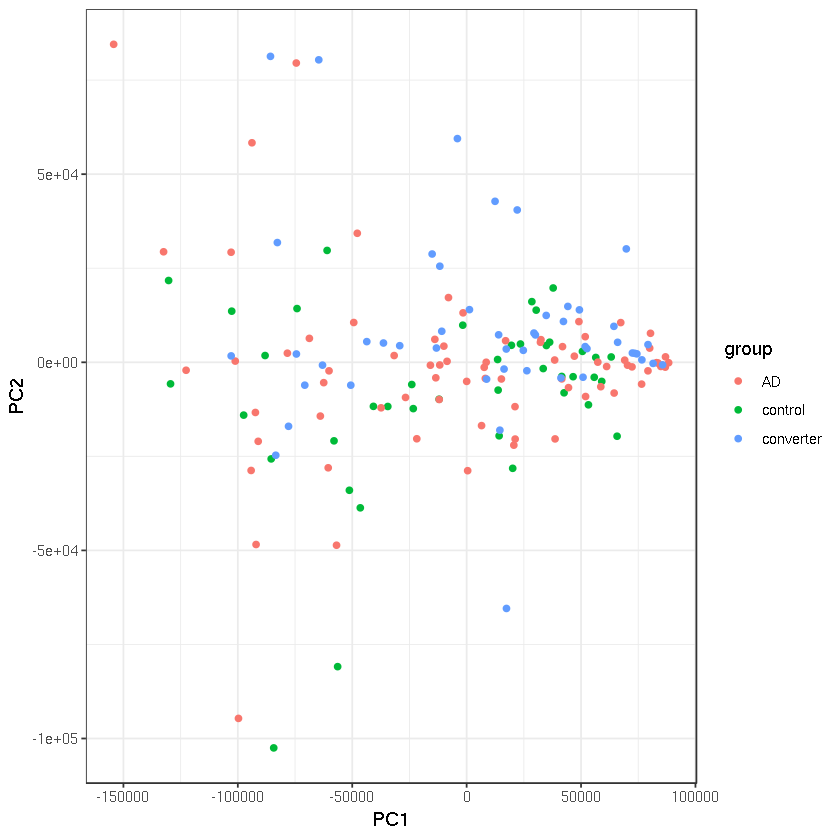

In [23]:
# Plot PCA
pca.dt <- cbind(meta.dt, pca$x)
ggplot(pca.dt, aes(x=PC1, PC2, color = group)) + geom_point() + theme_bw()
# PCA unable to classify patients into AD groups - need more sophisticated classifier

## Look into AMP-AD genes
Discussed in paper

In [24]:
ampgenes <- c("PBXIP1", "MID1IP1", "SLC25A18", "GFAP", "GNA12", "CRTAP", "QDPR", "GPRC5B", "PADI2",
             "NACC2", "RHOQ", "QKI", "CSRP1", "CALD1", "SASH1", "TNS3", "LAMP2", "ERBB2IP", "FAM107A",
             "PLXNB1", "AHNAK", "MYO10", "PDE4DIP", "ITPKB", "KCNJ10", "DOCK1","MRAS","PHGDH")


up.ampgenes <- c( "PADI2","NACC2", "RHOQ", "QKI", "CSRP1", "CALD1", "SASH1", "TNS3", "LAMP2", 
                 "ERBB2IP", "FAM107A","PLXNB1", "AHNAK", "MYO10", "PDE4DIP", "ITPKB", "KCNJ10", 
                 "DOCK1","MRAS","PHGDH")

down.ampgenes <- c("PBXIP1", "MID1IP1", "SLC25A18", "GFAP", "GNA12", "CRTAP", "QDPR", "GPRC5B")


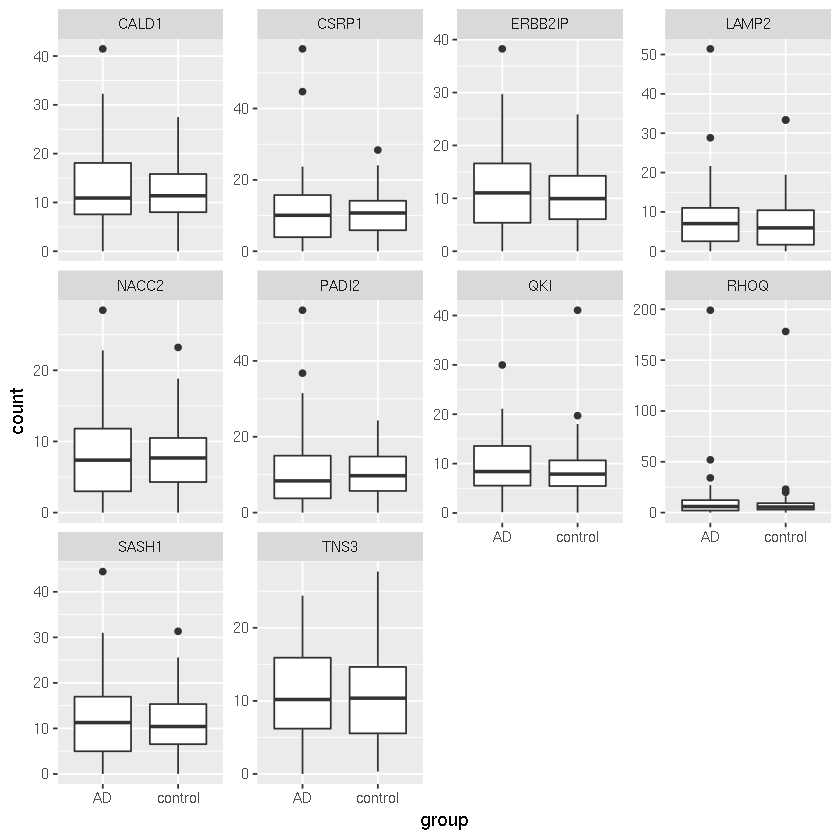

In [25]:
dt <- counts.longdt %>%
    filter(gene_name %in% up.ampgenes[1:10], group !="converter") 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")

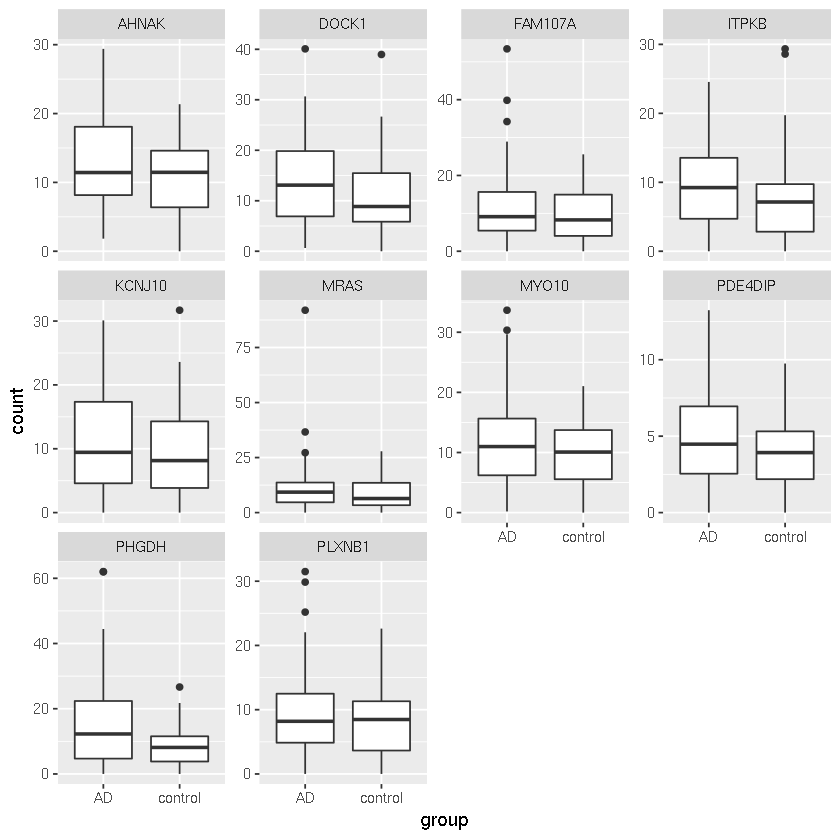

In [26]:
dt <- counts.longdt %>%
    filter(gene_name %in% up.ampgenes[11:20], group !="converter") 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")
# most AMP - AD genes are also upregulated in this data

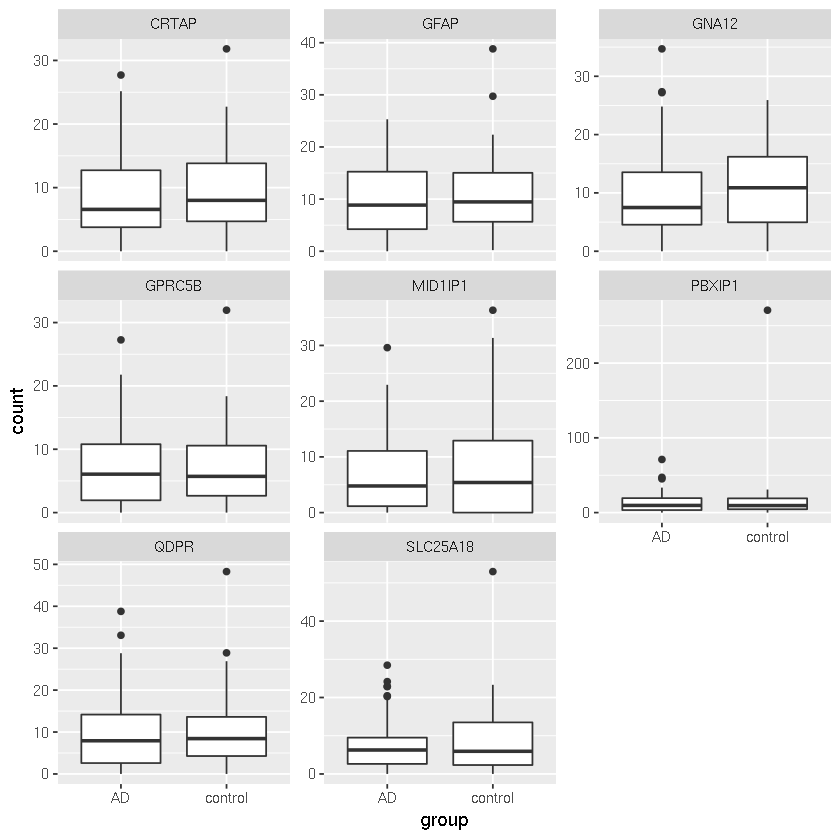

In [27]:
dt <- counts.longdt %>%
    filter(gene_name %in% down.ampgenes, group !="converter") 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")
# some AMP-AD genes are also downreg in this data

### Look at trends of these AMP-AD genes in converters over time
Not very consistent - may be hard to detect converters

In [28]:
# may want to remove converters who don't have post diagnosis measurements
rmv <- c("C_2", "C_3", "C_4", "C_7", "C_8")

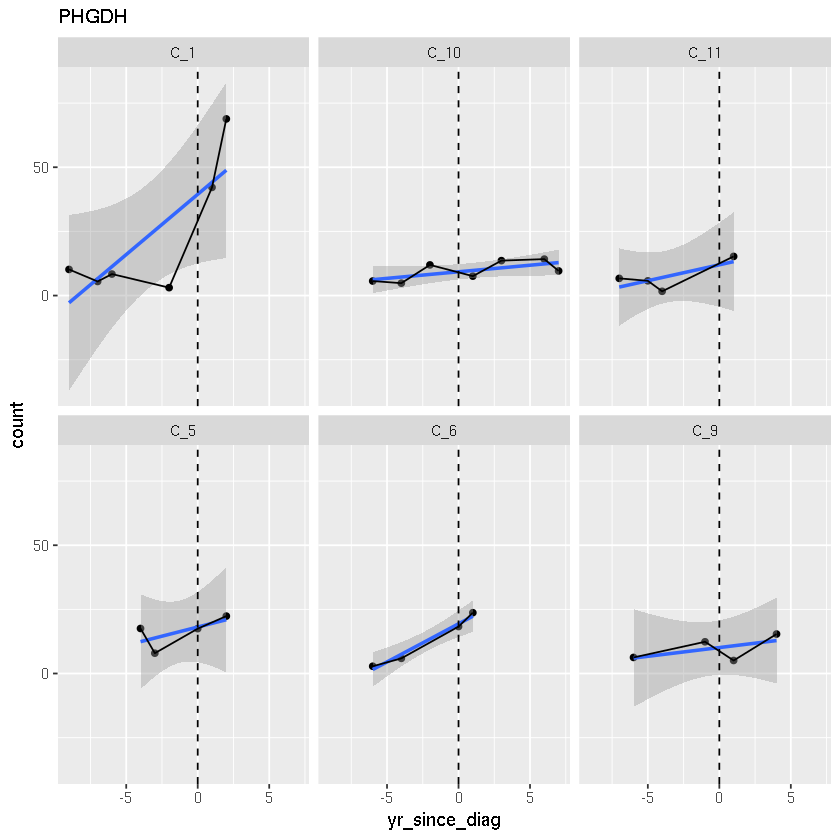

In [29]:
# plot converters for PHGDH
dt <- counts.longdt %>%
    filter(gene_name %in% ampgenes[28], group=="converter") %>%
    filter(!donorID %in% rmv)
# dt
ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
    geom_vline(xintercept = 0, linetype= "dashed") + 
    geom_line() + facet_wrap(~donorID) + ggtitle(ampgenes[28])

In [1]:
# # look at all upregulated genes over time
# for (g in up.ampgenes) {
#     dt <- counts.longdt %>%
#         filter(gene_name %in% g, group=="converter") %>%
#         filter(!donorID %in% rmv)
#     # dt
#     show(ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
#         geom_vline(xintercept = 0, linetype= "dashed") + 
#         geom_line() + facet_wrap(~donorID) + ggtitle(g))
# }
# # looks promising

In [2]:
# # look at all downregulated genes over time
# for (g in down.ampgenes) {
#     dt <- counts.longdt %>%
#         filter(gene_name %in% g, group=="converter") %>%
#         filter(!donorID %in% rmv)
#     # dt
#     show(ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
#         geom_vline(xintercept = 0, linetype= "dashed") + 
#         geom_line() + facet_wrap(~donorID) + ggtitle(g))
# }
# # downreg looks a little less promising

#### any linear trends in AD patients over time?
None seen from these genes

In [5]:
# # look at all upregulated genes over time in AD patients to see if there are linear trends
# dt <- counts.longdt %>%
#     filter(group=="AD")
# for (g in up.ampgenes[18:20]) {
#     dt1 <- dt %>%
#         filter(gene_name %in% g) %>%
#         arrange(year)
#     # dt
#     show(ggplot(dt1, aes(x=year,y=count)) + geom_point() + geom_smooth(method =  "lm") +
#         geom_line() + facet_wrap(~donorID,scales="free_x") + ggtitle(g)) 
# }

# # no trends from AD individuals

## SVM using known AMP-AD genes

In [33]:
# generate ad.status dataframe with the same sample order in counts.dt
# remove converters
keep <- meta.dt %>%
    filter(group !="converter") 
# keep
counts.filt <- select(counts.dt,c(1:3,keep$sample_id))
head(counts.filt)

ad.status <- keep %>% arrange(match(sample_id, colnames(counts.filt)[4:length(colnames(counts.filt))])) %>%
  select(sample_id, group)
head(ad.status)
tail(ad.status)

gene_id,gene_name,gene_biotype,N_1_01_1,N_1_05_1,N_1_07_1,N_1_08_1,N_1_09_1,N_2_00_1,N_2_01_1,⋯,AD_14_05_1,AD_14_07_1,AD_14_10_1,AD_14_13_1,AD_14_14_1,AD_15_04_1,AD_15_06_1,AD_15_00_1,AD_15_01_1,AD_15_03_1
ENSG00000223972,DDX11L1,transcribed_unprocessed_pseudogene,0,0,0.000000,0,0,1.256643,0,⋯,0,0,0,0,0.000000,0,0.00000,0,0,0
ENSG00000227232,WASH7P,unprocessed_pseudogene,0,0,1.458992,0,0,0.000000,0,⋯,0,0,0,0,0.000000,0,0.00000,0,0,0
ENSG00000278267,MIR6859-1,miRNA,0,0,0.000000,0,0,0.000000,0,⋯,0,0,0,0,0.000000,0,99.19039,0,0,0
ENSG00000243485,RP11-34P13.3,lincRNA,0,0,0.000000,0,0,0.000000,0,⋯,0,0,0,0,4.070087,0,0.00000,0,0,0
ENSG00000274890,MIR1302-2,miRNA,0,0,0.000000,0,0,0.000000,0,⋯,0,0,0,0,0.000000,0,0.00000,0,0,0
ENSG00000237613,FAM138A,lincRNA,0,0,0.000000,0,0,0.000000,0,⋯,0,0,0,0,0.000000,0,0.00000,0,0,0


sample_id,group
N_1_01_1,control
N_1_05_1,control
N_1_07_1,control
N_1_08_1,control
N_1_09_1,control
N_2_00_1,control


,sample_id,group
110,AD_14_14_1,AD
111,AD_15_04_1,AD
112,AD_15_06_1,AD
113,AD_15_00_1,AD
114,AD_15_01_1,AD
115,AD_15_03_1,AD


In [34]:
ad.status %>% dplyr::count(group)

group,n
AD,74
control,41


### SVM ranked by DESEq results of AD vs controls in 15 yr study
this does not produce the best AUC results

[1] "PHGDH"    "DOCK1"    "SLC25A18" "GFAP"     "MRAS"     "MYO10"   
 [7] "CRTAP"    "AHNAK"    "ITPKB"    "PDE4DIP"  "PBXIP1"   "GNA12"   
[13] "PLXNB1"   "PADI2"    "GPRC5B"   "NACC2"    "LAMP2"    "MID1IP1" 
[19] "RHOQ"     "QKI"      "KCNJ10"   "CSRP1"    "QDPR"     "CALD1"   
[25] "SASH1"    "ERBB2IP"  "TNS3"     "FAM107A"

[1] 0.496164

[1] 23

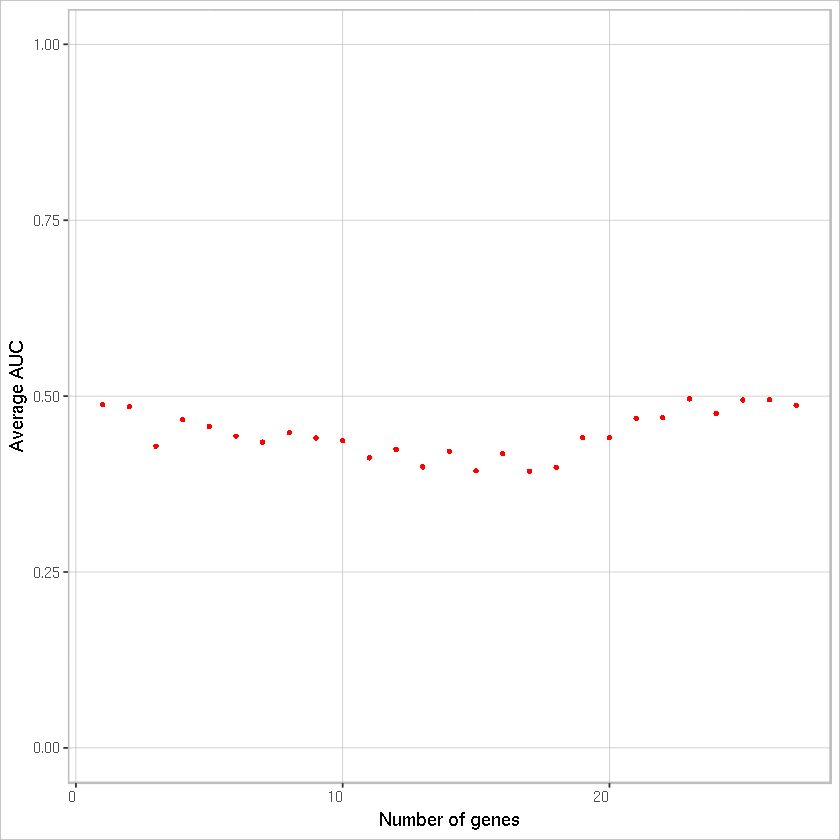

In [35]:
# # differential expression (DE) analysis of the biomarker genes ---------------
# # we use DESeq to calculate the DE p-value of each biomarker gene, 
# # then rank the marker genes by their p-values

res <- fread("./control_AD_DE_genes.csv",stringsAsFactor=F)
rank_marker_gene <- res %>% filter(gene_name %in% ampgenes) %>%
  arrange(pvalue) %>% .$gene_name
rank_marker_gene


# calculate average AUC of SVM based on each subset of biomarker genes 
# need several minutes to complete the loop
averageAUC <- rep(0, length(rank_marker_gene)-1) 
for(i in 2:length(rank_marker_gene)){
#     print(i)
  temp.tpm <- counts.filt %>% filter(gene_name %in% rank_marker_gene[1:i]) %>%
        select(-gene_id,-gene_biotype) %>%
    column_to_rownames("gene_name") %>% t() %>% as.data.frame() %>%
    mutate(status = as.factor(ifelse(ad.status$group == "AD", 1, 0)))
  
  idx_pos <- which(temp.tpm$status == 1)
  idx_neg <- which(temp.tpm$status == 0)
  
  # random sampling of trainging and testing dataset, 100 times average auc
  auc <- sapply(1:100, FUN = function(x){
    #### size of training/test sets = 80/20
      
    # trainning set 32 pos vs 32 neg, test set 42 pos vs 9 neg 
    idx_testset <- c(sample(idx_pos, 42),sample(idx_neg, 9))
    
    testset <- temp.tpm[idx_testset, ]
    trainset <- temp.tpm[-idx_testset, ]
    
    idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
    if(length(idx_zero_train) > 0){
      trainset <- trainset[, -idx_zero_train]
      testset <- testset[, -idx_zero_train]
     
  set.seed(123) # seed for random number, for reproducible results
     }
    # use svm function in e1071 package to train SVM model,
    # and then use ROCR function to calculate ROC curve data and auc
    svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
    svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
    pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
    perf_auc <- as.numeric(performance(pred, "auc")@y.values)

    return(perf_auc)
  })
      
  averageAUC[i-1] <- mean(auc)
}



# plot the number of biomarker against average AUC plot 

data.frame(geneNum = 1:(length(rank_marker_gene)-1), averageAUC = averageAUC) %>%
  ggplot(aes(x = geneNum, y = averageAUC)) +
  geom_point(shape=16, color = 'red',size=1.2) + 
  scale_y_continuous(limits = 0:1) +
  theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
        panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
        panel.grid.major = element_line(colour = "grey",size=0.2),
        panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
  labs(x = 'Number of genes', y = 'Average AUC',fill = '') + 
  theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
        axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
        legend.text = element_text(size = 8)) 

# max genes from this
max(averageAUC)
which(averageAUC == max(averageAUC))

In [36]:
# # ## add in all permutations of rank marker genes
# # # try over all permutations of rank marker genes
# # gene.cmbs <- list()

# # gene.cmbs <- list(gene.cmbs,combn(rank_marker_gene, 2,simplify = F) )
# # gene.cmbs <- list(gene.cmbs,combn(rank_marker_gene, 3,simplify = F) )


# gene.cmbs <- combn(rank_marker_gene, 2,simplify = F)
# for (l in 3:length(rank_marker_gene)) {
#     t2 <- combn(rank_marker_gene, l,simplify = F)
#     gene.cmbs <- append(gene.cmbs,t2)
# }
# length(gene.cmbs)
# head(gene.cmbs)
# tail(gene.cmbs)

## takes too long

## SVM with AMP-AD ordered genes 
Ordered from paper

In [75]:
meta.dt %>% 
    filter(group != "converter") %>%
    dplyr::count(group)

group,n
AD,74
control,41


[1] 0.5736508

[1] 21

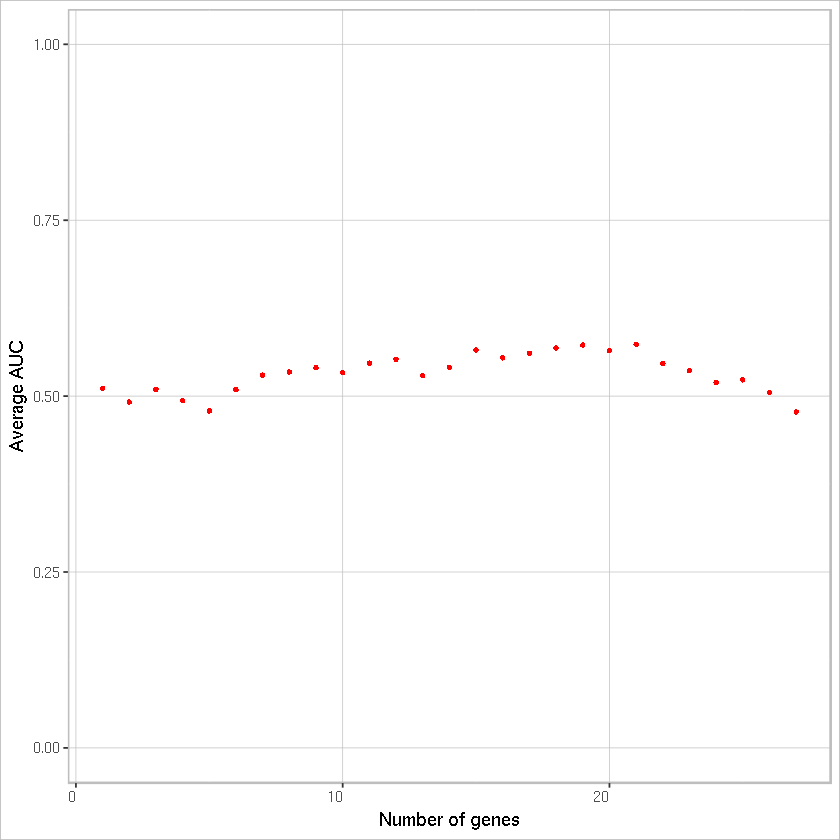

In [61]:
## Try with AMP-AD ordered genes
# calculate average AUC of SVM based on each subset of biomarker genes 
# need several minutes to complete the loop

# decreasing log2fc order
rank.ampgenes <- rev(ampgenes)
averageAUC1 <- rep(0, length(rank.ampgenes)-1) 
for(i in 2:length(rank.ampgenes)){
#     print(i)
  temp.tpm <- counts.filt %>% filter(gene_name %in% rank.ampgenes[1:i]) %>%
        select(-gene_id,-gene_biotype) %>%
    column_to_rownames("gene_name") %>% t() %>% as.data.frame() %>%
    mutate(status = as.factor(ifelse(ad.status$group == "AD", 1, 0)))
  
  idx_pos <- which(temp.tpm$status == 1)
  idx_neg <- which(temp.tpm$status == 0)
  
  # random sampling of trainging and testing dataset, 100 times average auc
  auc <- sapply(1:100, FUN = function(x){
    #### size of training/test sets = 80/20
    # trainning set 32 pos vs 32 neg, test set 42 pos vs 9 neg 
    idx_testset <- c(sample(idx_pos, 42),sample(idx_neg, 9))
    
    testset <- temp.tpm[idx_testset, ]
    trainset <- temp.tpm[-idx_testset, ]
    
    idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
    if(length(idx_zero_train) > 0){
      trainset <- trainset[, -idx_zero_train]
      testset <- testset[, -idx_zero_train]
     
  set.seed(123) # seed for random number, for reproducible results
 }
    # use svm function in e1071 package to train SVM model,
    # and then use ROCR function to calculate ROC curve data and auc
    svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
    svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
    pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
    perf_auc <- as.numeric(performance(pred, "auc")@y.values)

    return(perf_auc)
  })
      
  averageAUC1[i-1] <- mean(auc)
}

# plot the number of biomarker against average AUC plot 
data.frame(geneNum = 1:(length(rank.ampgenes)-1), averageAUC1 = averageAUC1) %>%
  ggplot(aes(x = geneNum, y = averageAUC1)) +
  geom_point(shape=16, color = 'red',size=1.2) + 
  scale_y_continuous(limits = 0:1) +
  theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
        panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
        panel.grid.major = element_line(colour = "grey",size=0.2),
        panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
  labs(x = 'Number of genes', y = 'Average AUC',fill = '') + 
  theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
        axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
        legend.text = element_text(size = 8)) 

# max genes from this
max(averageAUC1)
which(averageAUC1 == max(averageAUC1))

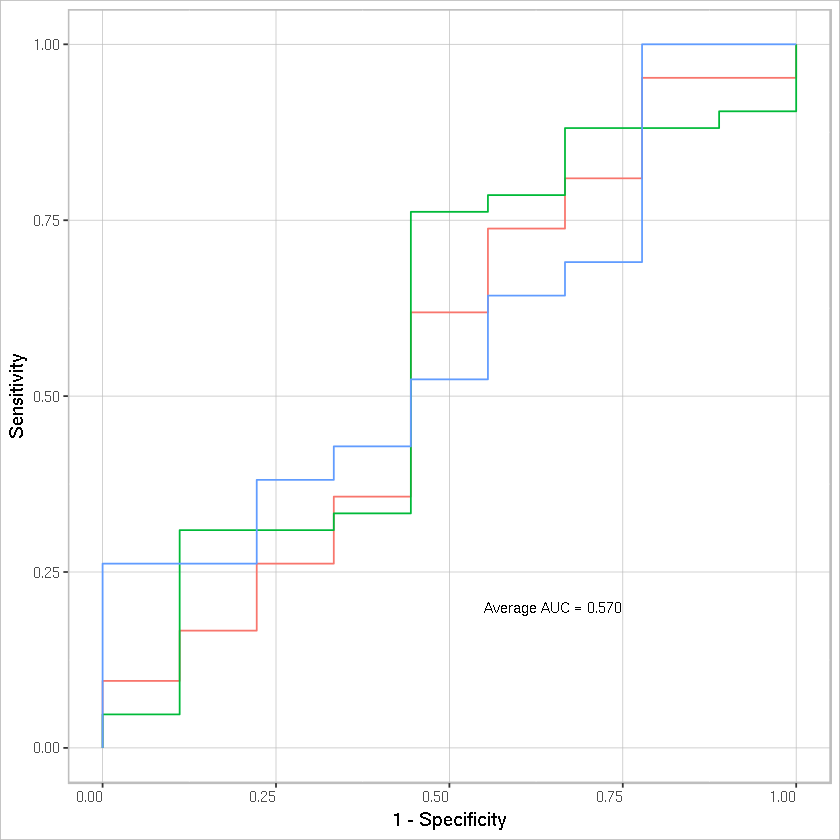

In [63]:
# select top 20 biomarker genes to plot 

temp.tpm <- counts.filt %>% filter(gene_name %in% rank.ampgenes[1:20]) %>%
    select(-gene_id,-gene_biotype) %>%
    column_to_rownames("gene_name") %>% t() %>% as.data.frame() %>%
    mutate(status = as.factor(ifelse(ad.status$group == "AD", 1, 0)))

idx_pos <- which(temp.tpm$status == 1)
idx_neg <- which(temp.tpm$status == 0)

set.seed(123)
# random sampling of trainging and testing dataset, 3 times

roc_data <- c()
auc <- c()
for(i in 1:3){
    idx_testset <- c(sample(idx_pos, 42),sample(idx_neg, 9))  
  testset <- temp.tpm[idx_testset, ]
  trainset <- temp.tpm[-idx_testset, ]
  
  idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
  if(length(idx_zero_train) > 0){
    trainset <- trainset[, -idx_zero_train]
    testset <- testset[, -idx_zero_train]
  }
  
  # use svm function in e1071 package to train SVM model,
  # and then use ROCR function to calculate ROC curve data and auc
  svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
  svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
  pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
  perf_roc <- performance(pred, "tpr", "fpr")
  roc_data <- rbind(roc_data, 
                    data.frame(runtime = as.factor(i), 
                               x = perf_roc@x.values[[1]], 
                               y = perf_roc@y.values[[1]]))
  perf_auc <- performance(pred, "auc")
  auc <- c(auc, as.numeric(perf_auc@y.values))
  
}

# plot roc curves from randomly generated roc_data

ggplot(roc_data, aes(x = x, y = y, group = runtime, col = runtime)) + geom_line() +
  labs(x = '1 - Specificity', y = 'Sensitivity',fill = '') +
  theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
        panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
        panel.grid.major = element_line(colour = "grey",size=0.2),
        panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
  theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
        axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
        legend.position = "none") +
  scale_y_continuous(limits = 0:1) +
  scale_x_continuous(limits = 0:1) +
  annotate('text',label = paste0('Average AUC = ',format(round(mean(auc), 2), nsmall = 3)), 
           x = 0.65, y=0.2, size = 3)

In [64]:
# # select top 4 biomarker genes to plot 

# temp.tpm <- counts.filt %>% filter(gene_name %in% rank.ampgenes[1:4]) %>%
#     select(-gene_id,-gene_biotype) %>%
#     column_to_rownames("gene_name") %>% t() %>% as.data.frame() %>%
#     mutate(status = as.factor(ifelse(ad.status$group == "AD", 1, 0)))

# idx_pos <- which(temp.tpm$status == 1)
# idx_neg <- which(temp.tpm$status == 0)

# set.seed(123)
# # random sampling of trainging and testing dataset, 3 times

# roc_data <- c()
# auc <- c()
# for(i in 1:3){
#     idx_testset <- c(sample(idx_pos, 42),sample(idx_neg, 9))  
#   testset <- temp.tpm[idx_testset, ]
#   trainset <- temp.tpm[-idx_testset, ]
  
#   idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
#   if(length(idx_zero_train) > 0){
#     trainset <- trainset[, -idx_zero_train]
#     testset <- testset[, -idx_zero_train]
#   }
  
#   # use svm function in e1071 package to train SVM model,
#   # and then use ROCR function to calculate ROC curve data and auc
#   svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
#   svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
#   pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
#   perf_roc <- performance(pred, "tpr", "fpr")
#   roc_data <- rbind(roc_data, 
#                     data.frame(runtime = as.factor(i), 
#                                x = perf_roc@x.values[[1]], 
#                                y = perf_roc@y.values[[1]]))
#   perf_auc <- performance(pred, "auc")
#   auc <- c(auc, as.numeric(perf_auc@y.values))
  
# }

# # plot roc curves from randomly generated roc_data

# ggplot(roc_data, aes(x = x, y = y, group = runtime, col = runtime)) + geom_line() +
#   labs(x = '1 - Specificity', y = 'Sensitivity',fill = '') +
#   theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
#         panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
#         panel.grid.major = element_line(colour = "grey",size=0.2),
#         panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
#   theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
#         axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
#         legend.position = "none") +
#   scale_y_continuous(limits = 0:1) +
#   scale_x_continuous(limits = 0:1) +
#   annotate('text',label = paste0('Average AUC = ',format(round(mean(auc), 2), nsmall = 3)), 
#            x = 0.65, y=0.2, size = 3)

## SVM with AMP-AD genes ranked by absolute value of LOG2FC
This does not perform as well as AMP-AD ranked genes from paper

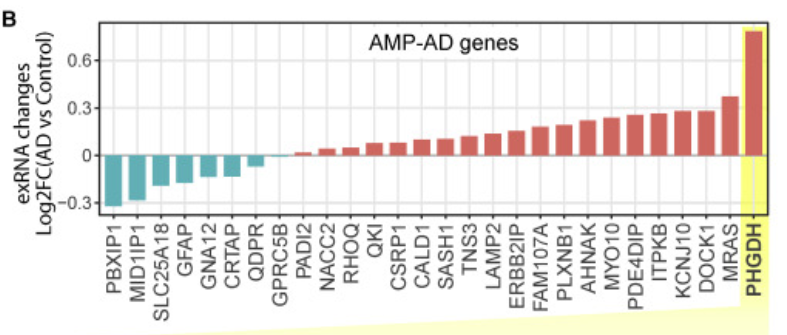

In [39]:
# try with absolute value log2fc
# log2fc extracted from Figure in paper above
ranklog.ampgenes.dt <- read.csv("./amp_ad_log2fc.csv",stringsAsFactor=F, header=F) %>%
    mutate(gene=ampgenes) %>%
    select(-V1) %>%
    select(gene,V2) %>%
    `colnames<-`(c("gene","log2fc") ) %>%
    arrange(desc(abs(log2fc)))
ranklog.ampgenes.dt

gene,log2fc
PHGDH,0.77880795
MRAS,0.37350993
PBXIP1,-0.31788079
DOCK1,0.29006623
MID1IP1,-0.28211921
KCNJ10,0.27814570
ITPKB,0.26622517
PDE4DIP,0.25430464
MYO10,0.23642384
AHNAK,0.21854305


[1] 0.5011111

[1] 27

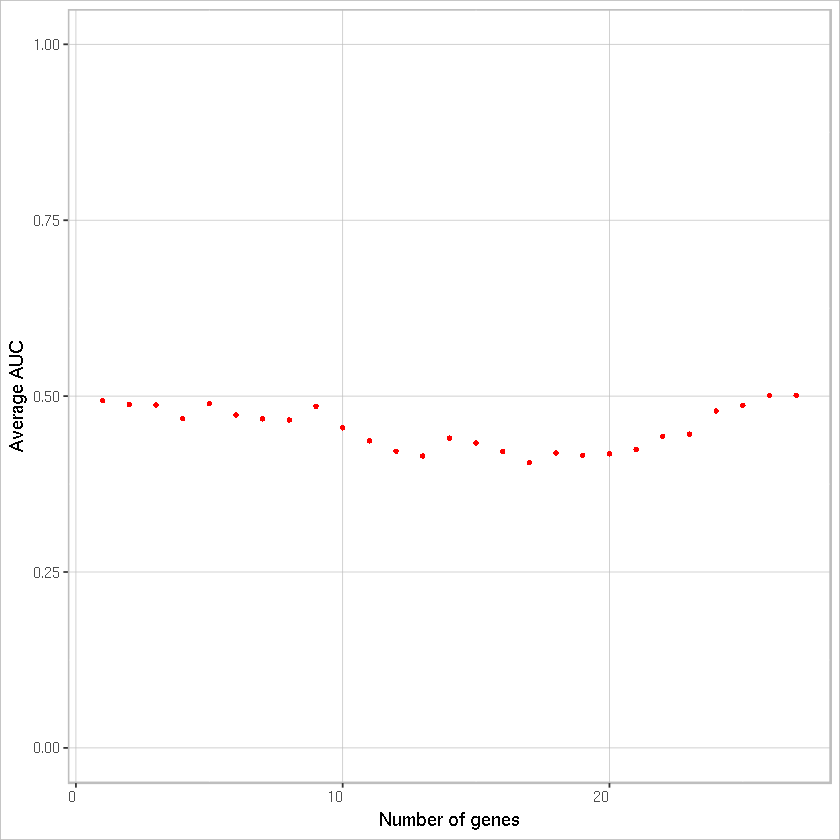

In [40]:
## Try with AMP-T2D ordered genes by log2fc absolute value
# calculate average AUC of SVM based on each subset of biomarker genes 
# need several minutes to complete the loop

# decreasing log2fc order
ranklog.ampgenes <- ranklog.ampgenes.dt$gene
averageAUC1 <- rep(0, length(ranklog.ampgenes)-1) 
for(i in 2:length(ranklog.ampgenes)){
#     print(i)
  temp.tpm <- counts.filt %>% filter(gene_name %in% ranklog.ampgenes[1:i]) %>%
        select(-gene_id,-gene_biotype) %>%
    column_to_rownames("gene_name") %>% t() %>% as.data.frame() %>%
    mutate(status = as.factor(ifelse(ad.status$group == "AD", 1, 0)))
  
  idx_pos <- which(temp.tpm$status == 1)
  idx_neg <- which(temp.tpm$status == 0)
  
  # random sampling of trainging and testing dataset, 100 times average auc
  auc <- sapply(1:100, FUN = function(x){
    #### size of training/test sets = 80/20
    # trainning set 32 pos vs 32 neg, test set 42 pos vs 9 neg 
    idx_testset <- c(sample(idx_pos, 42),sample(idx_neg, 9))
    
    testset <- temp.tpm[idx_testset, ]
    trainset <- temp.tpm[-idx_testset, ]
    
    idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
    if(length(idx_zero_train) > 0){
      trainset <- trainset[, -idx_zero_train]
      testset <- testset[, -idx_zero_train]
     
  set.seed(123) # seed for random number, for reproducible results
 }
    # use svm function in e1071 package to train SVM model,
    # and then use ROCR function to calculate ROC curve data and auc
    svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
    svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
    pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
    perf_auc <- as.numeric(performance(pred, "auc")@y.values)

    return(perf_auc)
  })
      
  averageAUC1[i-1] <- mean(auc)
}

# plot the number of biomarker against average AUC plot 
data.frame(geneNum = 1:(length(ranklog.ampgenes)-1), averageAUC1 = averageAUC1) %>%
  ggplot(aes(x = geneNum, y = averageAUC1)) +
  geom_point(shape=16, color = 'red',size=1.2) + 
  scale_y_continuous(limits = 0:1) +
  theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
        panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
        panel.grid.major = element_line(colour = "grey",size=0.2),
        panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
  labs(x = 'Number of genes', y = 'Average AUC',fill = '') + 
  theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
        axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
        legend.text = element_text(size = 8)) 

# max genes from this
max(averageAUC1)
which(averageAUC1 == max(averageAUC1))

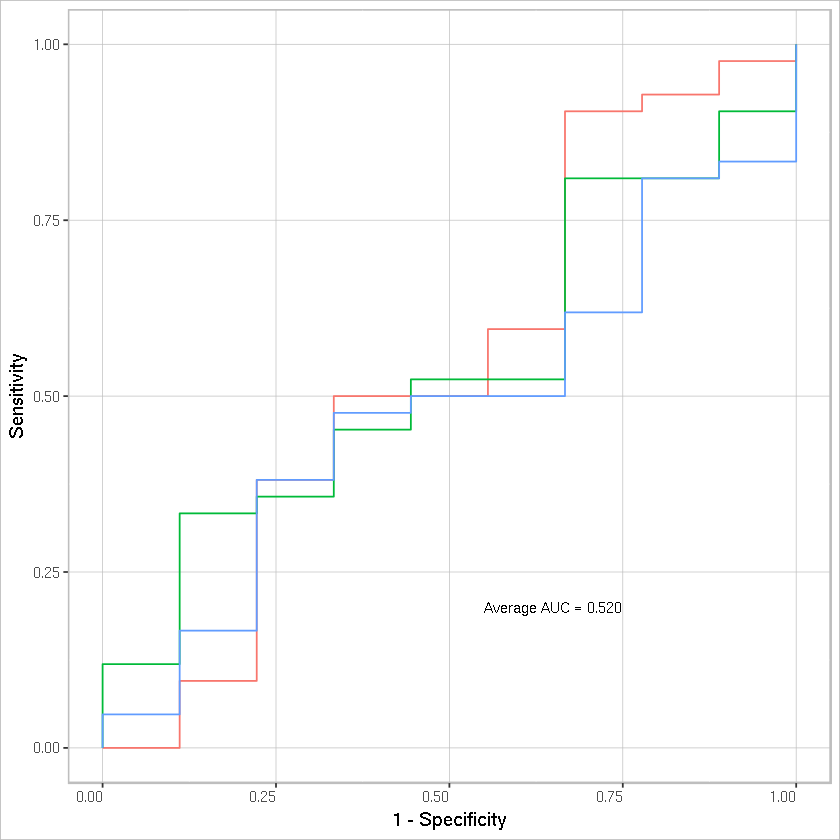

In [43]:
# select top 10 biomarker genes to plot 

temp.tpm <- counts.filt %>% filter(gene_name %in% ranklog.ampgenes[1:27]) %>%
    select(-gene_id,-gene_biotype) %>%
    column_to_rownames("gene_name") %>% t() %>% as.data.frame() %>%
    mutate(status = as.factor(ifelse(ad.status$group == "AD", 1, 0)))

idx_pos <- which(temp.tpm$status == 1)
idx_neg <- which(temp.tpm$status == 0)

set.seed(123)
# random sampling of trainging and testing dataset, 3 times

roc_data <- c()
auc <- c()
for(i in 1:3){
    idx_testset <- c(sample(idx_pos, 42),sample(idx_neg, 9))  
  testset <- temp.tpm[idx_testset, ]
  trainset <- temp.tpm[-idx_testset, ]
  
  idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
  if(length(idx_zero_train) > 0){
    trainset <- trainset[, -idx_zero_train]
    testset <- testset[, -idx_zero_train]
  }
  
  # use svm function in e1071 package to train SVM model,
  # and then use ROCR function to calculate ROC curve data and auc
  svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
  svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
  pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
  perf_roc <- performance(pred, "tpr", "fpr")
  roc_data <- rbind(roc_data, 
                    data.frame(runtime = as.factor(i), 
                               x = perf_roc@x.values[[1]], 
                               y = perf_roc@y.values[[1]]))
  perf_auc <- performance(pred, "auc")
  auc <- c(auc, as.numeric(perf_auc@y.values))
  
}

# plot roc curves from randomly generated roc_data

ggplot(roc_data, aes(x = x, y = y, group = runtime, col = runtime)) + geom_line() +
  labs(x = '1 - Specificity', y = 'Sensitivity',fill = '') +
  theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
        panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
        panel.grid.major = element_line(colour = "grey",size=0.2),
        panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
  theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
        axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
        legend.position = "none") +
  scale_y_continuous(limits = 0:1) +
  scale_x_continuous(limits = 0:1) +
  annotate('text',label = paste0('Average AUC = ',format(round(mean(auc), 3), nsmall = 3)), 
           x = 0.65, y=0.2, size = 3)

In [44]:
# ### Example linear mixed model
# library(lme4)
# lmer(log2(count+1) ~ yr_since_diag + group + sex)